# Comparing Nonlinearities

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

from custompackage.load_architecture import *
from custompackage.load_data import *
from custompackage.traintestloop import *

import sparselinear as sl
import custompackage.sl_custom as slc

import hyperopt as hp
%matplotlib inline

np.set_printoptions(suppress=True)

import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [7]:
class Nonlinearities():
    '''
    Establish nonlinearity, synapse status, directory, leak
    
    '''
    def __init__(self, model_type='ktree', activation='relu', selector=0, dataset='mnist', 
                 DIR='./results/temp/', Synapse=False, leak=0.01, positive=False):
        
        self.model_type = model_type
        self.activation = activation
        self.selector = selector
        self.dataset = dataset
        self.DIR = DIR
        self.Synapse = Synapse
        self.leak = leak
        self.positive = positive
        
        if self.Synapse == True:
            self.syn_key = 'syn'
        else:
            self.syn_key = 'nosyn'
            
        if self.positive == True:
            self.pos_key = 'pos'
        else:
            self.pos_key = 'posneg'
        
    def objective(self):
        
        if self.model_type == 'fcnn':
            lr_dict = pickle.load(open('./results/hyperparameters/20210207_fcnn_lr.hyperopt', 'rb'))
        else:
            lr_dict = pickle.load(open('./results/hyperparameters/20210207_ktree_lr.hyperopt', 'rb'))
            
        # Learning rate
        if self.activation == 'sqgl':
            lr = lr_dict[self.activation][self.dataset][self.syn_key][self.pos_key]['lr']
        else:
            lr = lr_dict[self.activation][self.dataset][self.syn_key]['lr']
        
        # SQGL parameters if appropriate
        atten = 0.5
        scale = 1
        
        # Initialize settings
        bs = 256
        weighting = 'paired'
        trials = 10
        epochs = 2000
        trees_set = [1, 2, 4, 8, 16, 32]

        # Load class-dataset list
        classes = np.load('./results/classes.npy', allow_pickle=True)
        classes = [classes[self.selector]]

        # Initialize recording
        acc = np.zeros((len(classes), trials, len(trees_set)))
        loss = np.zeros((len(classes), trials, len(trees_set)))
#         sqgl_params = np.zeros((len(classes), trials, len(trees_set), 3))
        
        # For each dataset enumerated from classes list
        for j, (t1, t2, ds) in enumerate(classes):
            print(t1, t2, ds)
            # Load data loaders
            trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds, permute=False)
            # Initialize input size for model initialization purposes
            input_size = trainloaders[0].dataset.tensors[0][0].shape[0]
            # For each trial
            for i in range(trials):
                # For each tree number:
                for k, trees in enumerate(trees_set):
                    print(j, i, k)

                    acc[j,i,k], loss[j,i,k] = self.model_and_train(ds,
                                                                   input_size, 
                                                                   trees, 
                                                                   scale, 
                                                                   atten, 
                                                                   trainloaders[i], 
                                                                   validloaders[i],
                                                                   testloader, 
                                                                   epochs, 
                                                                   lr)
                    
                    file_label = '_'.join((self.model_type,self.activation,self.syn_key,self.pos_key,str(self.leak*100),self.dataset))
#                     np.save(self.DIR+'sqgl_params_'+file_label, sqgl_params)
                    np.save(self.DIR+'acc_'+file_label, acc)
                    np.save(self.DIR+'loss_'+file_label, loss)
                    
    def model_and_train(self,ds, input_size, trees, scale, atten, trainloader, validloader, testloader, epochs,lr):
        if self.model_type == 'fcnn':
            if self.Synapse == True:
                model = synapse_fcnn(Input_size=input_size, Hidden_size=trees*2, Output_size=1,
                                     Activation=self.activation, learn=False, alpha=1, beta=1, gamma=1, 
                                     scale=scale, atten=atten, leak=self.leak).cuda()
            else:
                model = simple_fcnn(Input_size=input_size, Hidden_size=trees*2, Output_size=1,
                                     Activation=self.activation, learn=False, alpha=1, beta=1, gamma=1, 
                                     scale=scale, atten=atten, leak=self.leak).cuda()
        else:
            if self.Synapse == True:
                model = ktree_synapse(ds=ds, Repeats=trees, Padded=True, Activation=self.activation, 
                                     learn=False, alpha=1, beta=1, gamma=1, scale=scale, atten=atten,
                                     leak=self.leak, Node_vary=False, positive=self.positive).cuda()
            else:
                model = ktree_sparse(ds=ds, Repeats=trees, Padded=True, Activation=self.activation, 
                                     learn=False, alpha=1, beta=1, gamma=1, scale=scale, atten=atten,
                                     synapse=False, leak=self.leak, Node_vary=False, positive=self.positive).cuda()
        #Train and test ktree, assigning loss and acc values
        if self.Synapse == True and self.model_type == 'ktree':
            loss_curve, acc_curve, loss, acc, model_t = train_test_ktree_synapse(model, trainloader,
                                                                            validloader, testloader, 
                                                                            epochs = epochs, randorder=False,
                                                                            lr=lr)
        else:
            loss_curve, acc_curve, loss, acc, model_t = train_test_ktree_sparse(model, trainloader,
                                                                            validloader, testloader, 
                                                                            epochs = epochs, randorder=False,
                                                                            lr=lr)

#         sqgl_params= np.array([model_t.sqgl.alpha, model_t.sqgl.beta, model_t.sqgl.gamma])
#         print(sqgl_params)
        return(acc, loss)

## ktree

### SQGL nosyn posneg

In [ ]:
testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=0, dataset='mnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=1, dataset='fmnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=2, dataset='kmnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=3, dataset='emnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=4, dataset='svhn', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=5, dataset='usps', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=6, dataset='cifar10', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=False)
testing_loop.objective()

### SQGL nosyn pos

In [ ]:
testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=0, dataset='mnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=1, dataset='fmnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=2, dataset='kmnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=3, dataset='emnist', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=4, dataset='svhn', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=5, dataset='usps', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=6, dataset='cifar10', 
             DIR='./results/20210210/', Synapse=False, leak=0, positive=True)
testing_loop.objective()

### SQGL syn posneg

In [ ]:
testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=0, dataset='mnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=1, dataset='fmnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=2, dataset='kmnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=3, dataset='emnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=4, dataset='svhn', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=5, dataset='usps', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=6, dataset='cifar10', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=False)
testing_loop.objective()

### SQGL syn pos

In [ ]:
testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=0, dataset='mnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=1, dataset='fmnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=2, dataset='kmnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=3, dataset='emnist', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=4, dataset='svhn', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=5, dataset='usps', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

testing_loop = Nonlinearities(model_type='ktree', activation='sqgl', selector=6, dataset='cifar10', 
             DIR='./results/20210210/', Synapse=True, leak=0, positive=True)
testing_loop.objective()

## FCNN

### SQGL nosyn

In [ ]:
classes = np.load('./results/classes.npy', allow_pickle=True)
classes = classes[:,2]

for selector, dataset in enumerate(classes):
    testing_loop = Nonlinearities(model_type='fcnn', activation='sqgl', selector=selector, dataset=dataset, 
                 DIR='./results/20210210/', Synapse=False, leak=0)
    testing_loop.objective()

### SQGL syn

In [ ]:
classes = np.load('./results/classes.npy', allow_pickle=True)
classes = classes[:,2]

for selector, dataset in enumerate(classes):
    testing_loop = Nonlinearities(model_type='fcnn', activation='sqgl', selector=selector, dataset=dataset, 
                 DIR='./results/20210210/', Synapse=True, leak=0)
    testing_loop.objective()

## Make figures for ktree and fcnn

In [224]:
def mean_std(acc_array, cutoff=0.535, sterr=True):
    '''
    Takes the mean and standard deviation of trials that are above the threshold cutoff value
    Inputs: accuracy array, dataset index, threshold cutoff
    Outputs: selected trial mean, selected trial standard deviation, number of selected trials
    '''
    idx_all = []
    mean_idx = np.zeros(6)
    std_idx = np.zeros(6)
    count_idx = np.zeros(6)
    
    for i in range(6):
        idxt = np.where(acc_array[0,:,i] > cutoff)
        idx_all.append(idxt)

    for j in range(6):
        count_idx[j] = len(idx_all[j][0])
        mean_idx[j] = np.mean(acc_array[0,idx_all[j],j]) 

        if sterr == True:
            std_idx[j] = scipy.stats.sem(acc_array[0,idx_all[j],j], axis=1)
        else:
            std_idx[j] = np.std(acc_array[0,idx_all[j],j])
    
    return(mean_idx, std_idx, count_idx)

def comparison(acc_array_1, acc_array_2, tree_setting=0, cutoff=0.55):
    '''
    T_test comparing selected trials that are above threshold cutoff
    Inputs: Accuracy array 1, accuracy array 2, dataset index, threshold cutoff
    '''
    # Record keeping
    compare = np.zeros(6)
    
    # Make selection index for first accuracy array
    idx_1 = []
    for i in range(6):
        idx = np.where(acc_array_1[0,:,i] > cutoff)
        idx = idx[0]
        idx = idx.tolist()
        idx_1.append(idx)

    # Make selection index for second accuracy array
    idx_2 = []
    for i in range(6):
        idx = np.where(acc_array_2[0,:,i] > cutoff)
        idx = idx[0]
        idx = idx.tolist()
        idx_2.append(idx)
    
    # Use selection indices to select data for t-test, record p-values
    for j in range(6):
        _, compare[j] = scipy.stats.ttest_ind(acc_array_1[0,idx_1[j],j], acc_array_2[0,idx_2[j],j])
        
    return(compare)

def comparison_array(acc_array, nonlin_keys_list, select_key, dataset, tree_setting=0, cutoff=0.55):
    '''
    T_test comparing selected trials that are above threshold cutoff
    Inputs: Accuracy array 1, accuracy array 2, dataset index, threshold cutoff
    '''
    # Record keeping
    nks = len(nonlin_keys_list)
    compare = np.ones((nks, 6))

    # Make selection index for first accuracy array
    
    idx_2 = np.zeros((nks), dtype=object)
    idx_select = []
    for j, nonlin_key in enumerate(nonlin_keys_list):
        idx_1 = []
        for i in range(6):
            idx = np.where(acc_array[nonlin_key][dataset][0,:,i] > cutoff)
            idx = idx[0]
            idx = idx.tolist()
            idx_1.append(idx)
            if nonlin_key == select_key:
                idx_select.append(idx)
        idx_2[j] = np.array((idx_1))
        if idx_2[j].size < 1:
            idx_2[j] = np.array((list([0]),list([]),list([]),list([]),list([]),list([]),))
        
    
    
    # Use selection indices to select data for t-test, record p-values
    for i, nonlin_key in enumerate(nonlin_keys_list):
        for j in range(6):
            if nonlin_key == select_key:
                break        
            _, compare[i, j] = scipy.stats.ttest_ind(acc_array[nonlin_key][dataset][0,idx_2[i][j],j], 
                                                     acc_array[select_key][dataset][0,idx_select[j],j])
        
    return(compare)

### Load data

### FCNN nonlins

In [317]:
DIR = './results/20210102/acc'
DIR_sqgl = './results/20210210/acc'

model_type = 'fcnn'
activations = ['relu', 'sigmoid', 'swish', 'sqgl']
syn_keys = ['nosyn','syn']
pos_keys = ['posneg','pos']
leaks = [0, 1.0]

trees_set = [1, 2, 4, 9, 16, 32]

classes = np.load('./results/classes.npy', allow_pickle=True)
datasets = classes[:,2]

acc = {}
nonlin_keys = []
for activation in activations:
    for syn_key in syn_keys:
        if activation != 'sqgl' and syn_key == 'syn':
            break
        
        for pos_key in pos_keys:
            
            if model_type != 'ktree' and pos_key == 'pos':
                break
        
            for leak in leaks:
                if activation != 'relu' and leak == 1.0:
                    break

                # Concatenate all datasets by nonlinearity
                nonlin_group = {}
                for dataset in datasets:
                    if activation == 'sqgl':
                        dataset_cache = np.load('_'.join((DIR_sqgl, model_type, activation, syn_key, pos_key, str(leak), dataset))+'.npy')
                    else:
                        dataset_cache = np.load('_'.join((DIR, model_type, activation, syn_key, str(leak), dataset))+'.npy')

                    nonlin_group[dataset] = dataset_cache

                nonlin_key = '_'.join((activation, syn_key, pos_key, str(leak)))
                nonlin_keys.append(nonlin_key)

                acc[nonlin_key] = nonlin_group

nonlin_keys

['relu_nosyn_posneg_0',
 'relu_nosyn_posneg_1.0',
 'sigmoid_nosyn_posneg_0',
 'swish_nosyn_posneg_0',
 'sqgl_nosyn_posneg_0',
 'sqgl_syn_posneg_0']

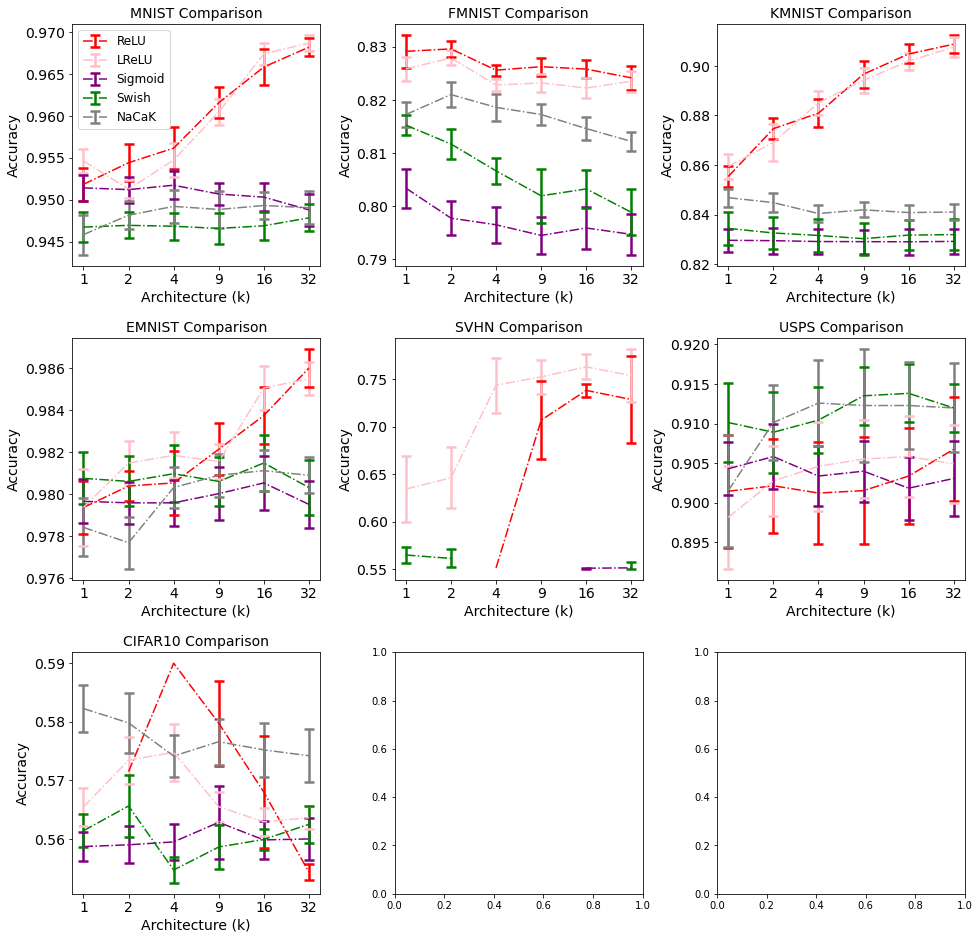

In [320]:
cutoff = 0.55

colors = ['red', 'pink', 'purple', 'green', 'grey', 'black']
dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
labels = ['ReLU', 'LReLU', 'Sigmoid', 'Swish', 'NaCaK']

acc_mean = np.zeros((7, 6, 6))
acc_std = np.zeros((7, 6, 6))
acc_counts = np.zeros((7, 6, 6))

# acc_mean = np.zeros((6,6))
# acc_std = np.zeros((6,6))
# acc_counts = np.zeros((6,6))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.3)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):

#     fig, ax = plt.subplots(figsize=(5,5))

    x = np.arange(len(trees_set))
        
    # FCNN
    for i, nonlin_key in enumerate(nonlin_keys[:5]): # Only sqgl nosyn case included
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
        ax[ds].errorbar(x, acc_mean[ds,i], yerr=acc_std[ds,i], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors[i])
        
    ax[ds].set_xticks(np.arange(len(trees_set)))
    ax[ds].set_xticklabels(trees_set, fontsize=14)
    ax[ds].set_ylabel('Accuracy', fontsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
    ax[ds].tick_params('y', labelsize=14)

    ax[ds].set_title(dataset_name[ds]+' Comparison', fontsize=14)
    ax[0].legend(labels, fontsize='large')
        
plt.savefig('./results/figures/fcnn_nonlins.svg', format='svg')


### p-vals

['relu_nosyn_posneg_0', 'relu_nosyn_posneg_1.0', 'sigmoid_nosyn_posneg_0', 'swish_nosyn_posneg_0', 'sqgl_nosyn_posneg_0', 'sqgl_syn_posneg_0']


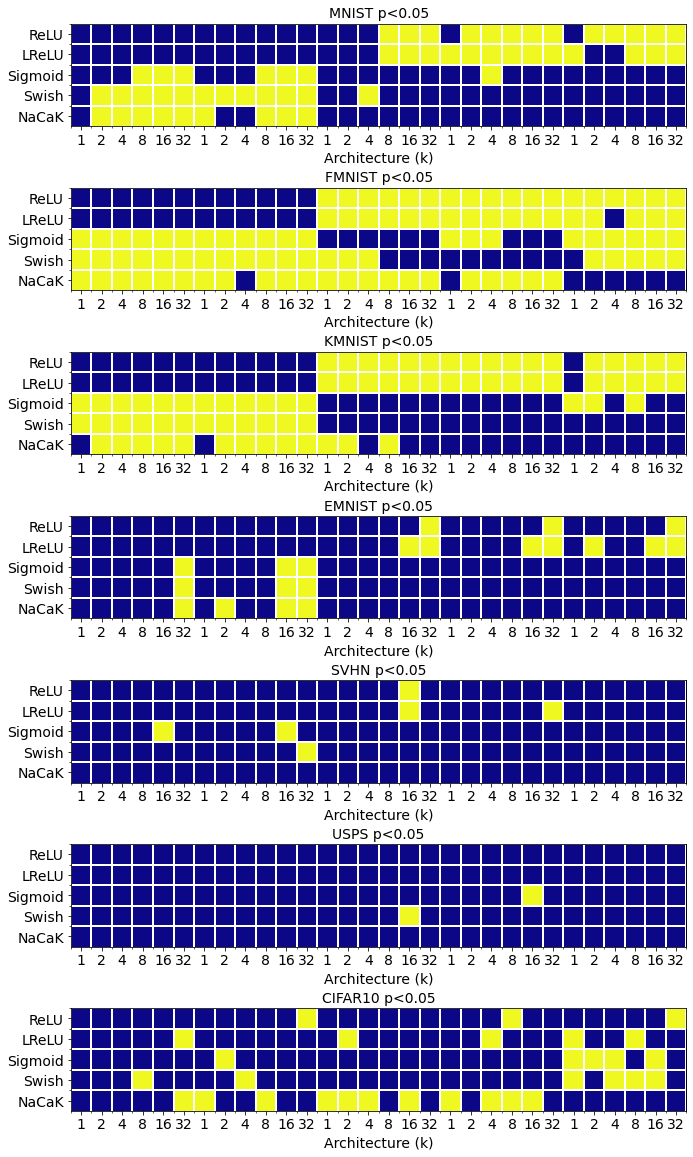

In [321]:
print(nonlin_keys)

dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
tree_set_labels = ['1','2','4','8','16','32']
list_of_k = (np.arange(0,6*5)).tolist()
nk_num = 5

fig, ax = plt.subplots(7, 1, figsize=(15,20))
fig.subplots_adjust(hspace = .6)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):
    p_val_set = np.ones((len(nonlin_keys[:nk_num]), nk_num*6))
    for nk, nonlin_key in enumerate(nonlin_keys[:nk_num]):
        p_vals = comparison_array(acc, nonlin_keys[:nk_num], nonlin_keys[nk], dataset)
        idx = np.isnan(p_vals)
        p_vals[idx] = 1
        p_val_set[nk] = np.concatenate((p_vals))
    
    ax[ds].imshow(p_val_set < 0.05, cmap='plasma')
    ax[ds].set_title(dataset_name[ds]+' p<0.05', fontsize=14)
    ax[ds].tick_params('both', labelsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)

   
    # Minor ticks
    ax[ds].set_xticks(np.arange(-.5, 6*nk_num, 1), minor=True)
    ax[ds].set_yticks(np.arange(-.5, 4, 1), minor=True)
    ax[ds].grid(which="minor", color="w", linestyle='-', linewidth=2)
    
    
    plt.setp(ax[ds], xticks=list_of_k, xticklabels=tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels,
            yticks=[0, 1, 2, 3, 4], yticklabels=labels)

plt.savefig('./results/figures/fcnn_nonlins_pval.svg', format='svg')
plt.show()

### ktree

In [306]:
DIR = './results/20210102/acc'
DIR_sqgl = './results/20210210/acc'
model_type = 'ktree'
activations = ['relu', 'sigmoid', 'swish', 'sqgl']
syn_keys = ['nosyn','syn']
leaks = [0, 1.0]

trees_set = [1, 2, 4, 8, 16, 32]

classes = np.load('./results/classes.npy', allow_pickle=True)
datasets = classes[:,2]

acc = {}
nonlin_keys = []
for activation in activations:
    for syn_key in syn_keys:
        if activation != 'sqgl' and syn_key == 'syn':
            break
        
        for pos_key in pos_keys:
            
            if activation != 'sqgl' and pos_key == 'pos':
                break
        
            for leak in leaks:
                if activation != 'relu' and leak == 1.0:
                    break

                # Concatenate all datasets by nonlinearity
                nonlin_group = {}
                for dataset in datasets:
                    if activation == 'sqgl':
                        dataset_cache = np.load('_'.join((DIR_sqgl, model_type, activation, syn_key, pos_key, str(leak), dataset))+'.npy')
                    else:
                        dataset_cache = np.load('_'.join((DIR, model_type, activation, syn_key, str(leak), dataset))+'.npy')

                    nonlin_group[dataset] = dataset_cache

                nonlin_key = '_'.join((activation, syn_key, pos_key, str(leak)))
                nonlin_keys.append(nonlin_key)

                acc[nonlin_key] = nonlin_group

nonlin_keys

['relu_nosyn_posneg_0',
 'relu_nosyn_posneg_1.0',
 'sigmoid_nosyn_posneg_0',
 'swish_nosyn_posneg_0',
 'sqgl_nosyn_posneg_0',
 'sqgl_nosyn_pos_0',
 'sqgl_syn_posneg_0',
 'sqgl_syn_pos_0']

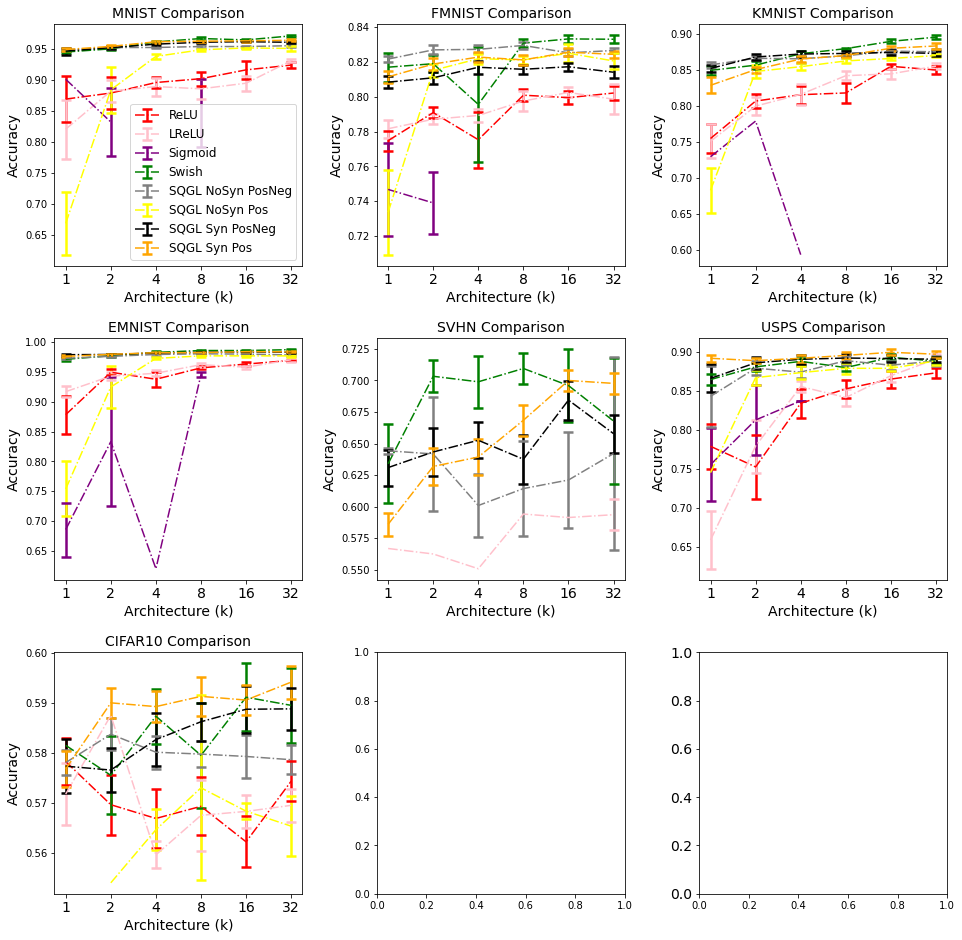

In [43]:
cutoff = 0.55

colors = ['red', 'pink', 'purple', 'green', 'grey', 'yellow', 'black', 'orange']
dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
labels = ['ReLU', 'LReLU', 'Sigmoid', 'Swish', 'SQGL NoSyn PosNeg','SQGL NoSyn Pos','SQGL Syn PosNeg','SQGL Syn Pos']

acc_mean = np.zeros((7, 8, 6))
acc_std = np.zeros((7, 8, 6))
acc_counts = np.zeros((7, 8, 6))

# acc_mean = np.zeros((6,6))
# acc_std = np.zeros((6,6))
# acc_counts = np.zeros((6,6))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.3)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):

#     fig, ax = plt.subplots(figsize=(5,5))

    x = np.arange(len(trees_set))
        
    # FCNN
    for i, nonlin_key in enumerate(nonlin_keys):
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
        ax[ds].errorbar(x, acc_mean[ds,i], yerr=acc_std[ds,i], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors[i])
        
    ax[ds].set_xticks(np.arange(len(trees_set)))
    ax[ds].set_xticklabels(trees_set, fontsize=14)
    ax[ds].set_ylabel('Accuracy', fontsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
    plt.tick_params('y', labelsize=14)

    ax[ds].set_title(dataset_name[ds]+' Comparison', fontsize=14)
    ax[0].legend(labels, fontsize='large')
        

### Compare Only NoSyn PosNeg SQGL to all other Nonlinearities

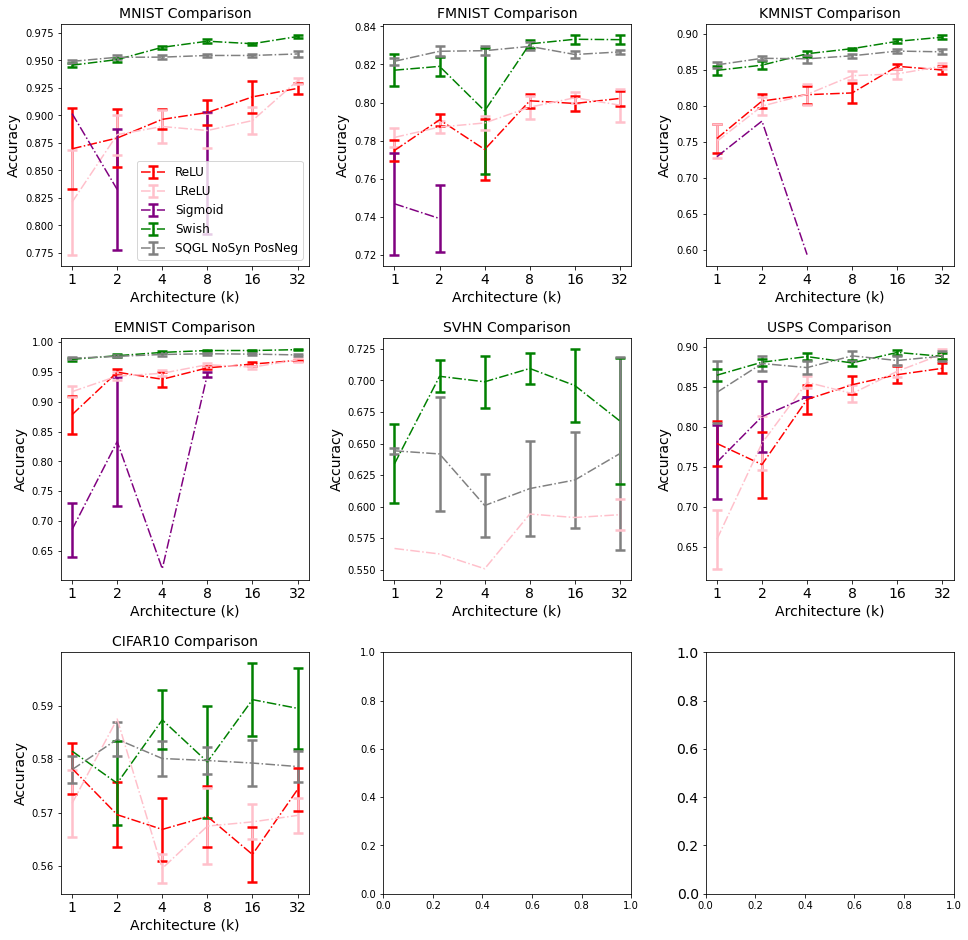

In [307]:
cutoff = 0.55

colors = ['red', 'pink', 'purple', 'green', 'grey']
dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
labels = ['ReLU', 'LReLU', 'Sigmoid', 'Swish', 'SQGL NoSyn PosNeg']

acc_mean = np.zeros((7, 8, 6))
acc_std = np.zeros((7, 8, 6))
acc_counts = np.zeros((7, 8, 6))

# acc_mean = np.zeros((6,6))
# acc_std = np.zeros((6,6))
# acc_counts = np.zeros((6,6))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.3)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):

#     fig, ax = plt.subplots(figsize=(5,5))

    x = np.arange(len(trees_set))
        
    # FCNN
    for i, nonlin_key in enumerate(nonlin_keys[:5]): ## Limiting to nonlinearities plus one sqgl
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
        ax[ds].errorbar(x, acc_mean[ds,i], yerr=acc_std[ds,i], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors[i])
        
    ax[ds].set_xticks(np.arange(len(trees_set)))
    ax[ds].set_xticklabels(trees_set, fontsize=14)
    ax[ds].set_ylabel('Accuracy', fontsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
    plt.tick_params('y', labelsize=14)

    ax[ds].set_title(dataset_name[ds]+' Comparison', fontsize=14)
    ax[0].legend(labels, fontsize='large')
        
plt.savefig('./results/figures/ktree_nonlins.svg', format='svg')


### Determine p-vals

['relu_nosyn_posneg_0', 'relu_nosyn_posneg_1.0', 'sigmoid_nosyn_posneg_0', 'swish_nosyn_posneg_0', 'sqgl_nosyn_posneg_0', 'sqgl_nosyn_pos_0', 'sqgl_syn_posneg_0', 'sqgl_syn_pos_0']


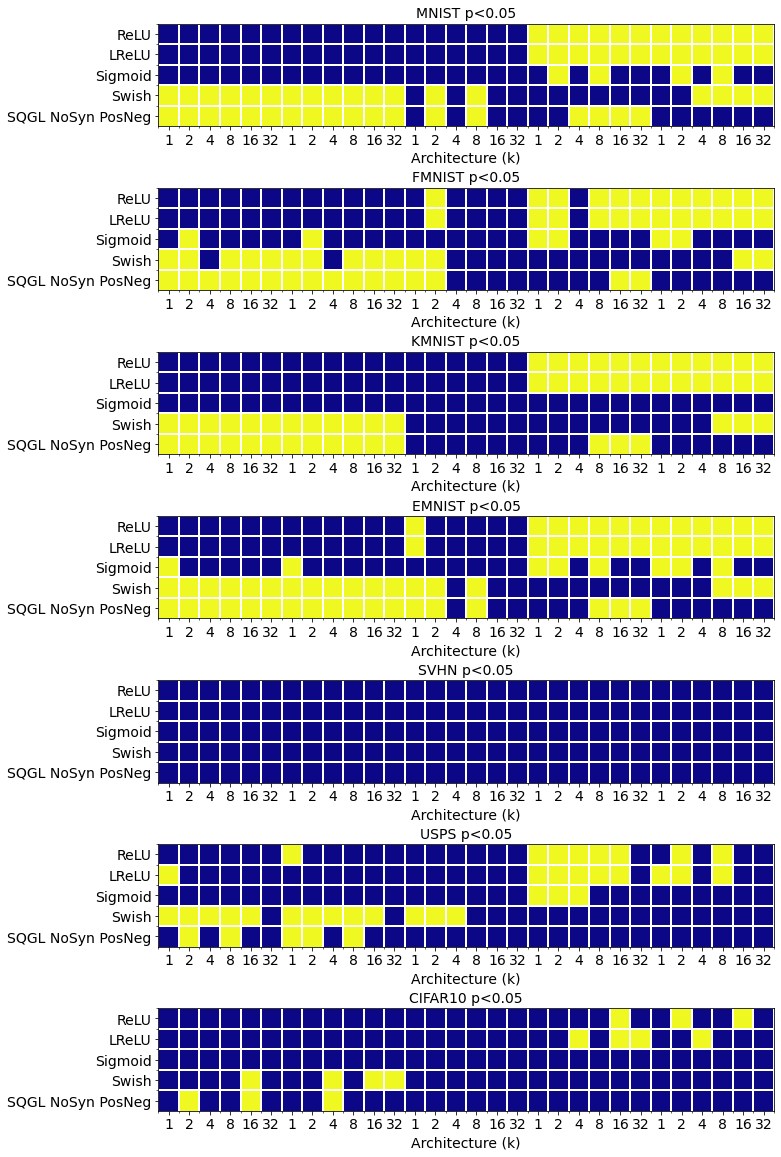

In [308]:
print(nonlin_keys)

dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
tree_set_labels = ['1','2','4','8','16','32']
list_of_k = (np.arange(0,6*5)).tolist()
nk_num = 5

fig, ax = plt.subplots(7, 1, figsize=(15,20))
fig.subplots_adjust(hspace = .6)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):
    p_val_set = np.ones((len(nonlin_keys[:nk_num]), nk_num*6))
    for nk, nonlin_key in enumerate(nonlin_keys[:nk_num]):
        p_vals = comparison_array(acc, nonlin_keys[:nk_num], nonlin_keys[nk], dataset)
        idx = np.isnan(p_vals)
        p_vals[idx] = 1
        p_val_set[nk] = np.concatenate((p_vals))
    
    ax[ds].imshow(p_val_set < 0.05, cmap='plasma')
    ax[ds].set_title(dataset_name[ds]+' p<0.05', fontsize=14)
    ax[ds].tick_params('both', labelsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)

   
    # Minor ticks
    ax[ds].set_xticks(np.arange(-.5, 6*nk_num, 1), minor=True)
    ax[ds].set_yticks(np.arange(-.5, 4, 1), minor=True)
    ax[ds].grid(which="minor", color="w", linestyle='-', linewidth=2)
    
    
    plt.setp(ax[ds], xticks=list_of_k, xticklabels=tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels,
            yticks=[0, 1, 2, 3, 4], yticklabels=labels)

plt.savefig('./results/figures/ktree_nonlins_pval.svg', format='svg')
plt.show()

### Compare Constant SQGL across models

In [322]:
DIR_f = './results/20210102/acc'
DIR_f_sqgl = './results/20210210/acc'
DIR_k = './results/20210102/acc'
DIR_k_sqgl = './results/20210210/acc'
model_types = ['ktree','fcnn']
activations = ['sqgl']
syn_keys = ['nosyn', 'syn']
pos_keys = ['posneg','pos']
leaks = [0]

trees_set = [1, 2, 4, 8, 16, 32]

classes = np.load('./results/classes.npy', allow_pickle=True)
datasets = classes[:,2]

acc_f = {}
acc_k = {}
nonlin_keys = []
acc = {}
for model_type in model_types:
    for activation in activations:
        for syn_key in syn_keys:
            if activation != 'sqgl' and syn_key == 'syn':
                break

            for pos_key in pos_keys:
                if model_type == 'fcnn' and pos_key == 'pos':
                    break

                for leak in leaks:
                    if activation != 'relu' and leak == 1.0:
                        break

                    nonlin_group = {}
                    for dataset in datasets:
                        if model_type == 'fcnn':
                            if activation == 'sqgl':
                                dataset_cache = np.load('_'.join((DIR_f_sqgl, model_type, activation, syn_key, pos_key, str(leak), dataset))+'.npy')
                            else:
                                dataset_cache = np.load('_'.join((DIR_f, model_type, activation, syn_key, str(leak), dataset))+'.npy')
                        else:
                            if activation == 'sqgl':
                                dataset_cache = np.load('_'.join((DIR_k_sqgl, model_type, activation, syn_key, pos_key, str(leak), dataset))+'.npy')
                            else:
                                dataset_cache = np.load('_'.join((DIR_k, model_type, activation, syn_key, str(leak), dataset))+'.npy')
                        
                        
                        nonlin_group[dataset] = dataset_cache

                    # Concatenate all datasets by nonlinearity
                    nonlin_key = '_'.join((model_type, activation, syn_key, pos_key, str(leak)))
                    nonlin_keys.append(nonlin_key)

                    acc[nonlin_key] = nonlin_group

acc_lin = np.load('./results/lda_score_test.npy')            

print(nonlin_keys)

['ktree_sqgl_nosyn_posneg_0', 'ktree_sqgl_nosyn_pos_0', 'ktree_sqgl_syn_posneg_0', 'ktree_sqgl_syn_pos_0', 'fcnn_sqgl_nosyn_posneg_0', 'fcnn_sqgl_syn_posneg_0']


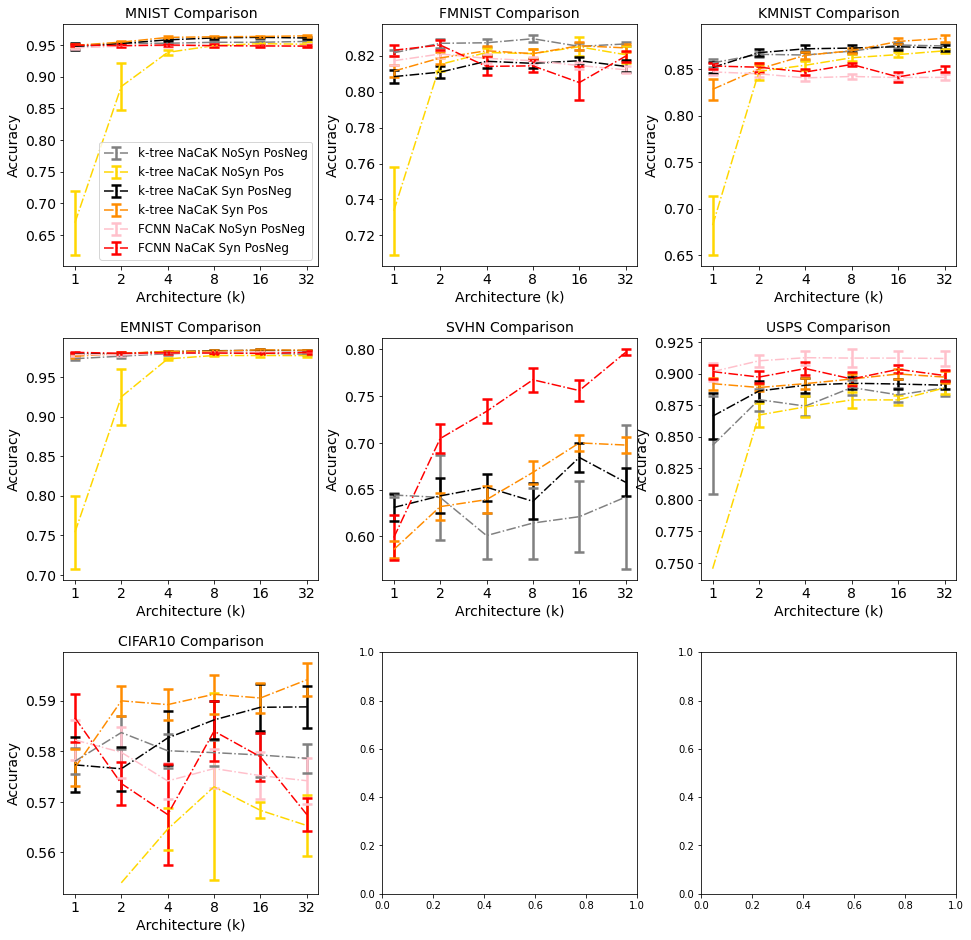

In [324]:
cutoff = 0.55

colors = ['grey', 'gold', 'black', 'darkorange', 'pink', 'red']
dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
labels = ['k-tree NaCaK NoSyn PosNeg',
         'k-tree NaCaK NoSyn Pos',
         'k-tree NaCaK Syn PosNeg',
         'k-tree NaCaK Syn Pos',
         'FCNN NaCaK NoSyn PosNeg',
         'FCNN NaCaK Syn PosNeg',]

acc_mean = np.zeros((7, 6, 6))
acc_std = np.zeros((7, 6, 6))
acc_counts = np.zeros((7, 6, 6))

# acc_mean = np.zeros((6,6))
# acc_std = np.zeros((6,6))
# acc_counts = np.zeros((6,6))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.25)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):

    x = np.arange(len(trees_set))
        
    # FCNN
    for i, nonlin_key in enumerate(nonlin_keys):
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
       
        ax[ds].errorbar(x, acc_mean[ds,i], yerr=acc_std[ds,i], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors[i])
        

    ax[ds].set_xticks(np.arange(len(trees_set)))
    ax[ds].set_xticklabels(trees_set, fontsize=14)
    ax[ds].set_ylabel('Accuracy', fontsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
    ax[ds].tick_params('y', labelsize=14)

    ax[ds].set_title(dataset_name[ds]+' Comparison', fontsize=14)
    ax[0].legend(labels, fontsize='large')
    
plt.savefig('./results/figures/constant_sqgl_compare_all.svg',format='svg')


['ktree_sqgl_nosyn_posneg_0', 'ktree_sqgl_nosyn_pos_0', 'ktree_sqgl_syn_posneg_0', 'ktree_sqgl_syn_pos_0', 'fcnn_sqgl_nosyn_posneg_0', 'fcnn_sqgl_syn_posneg_0']


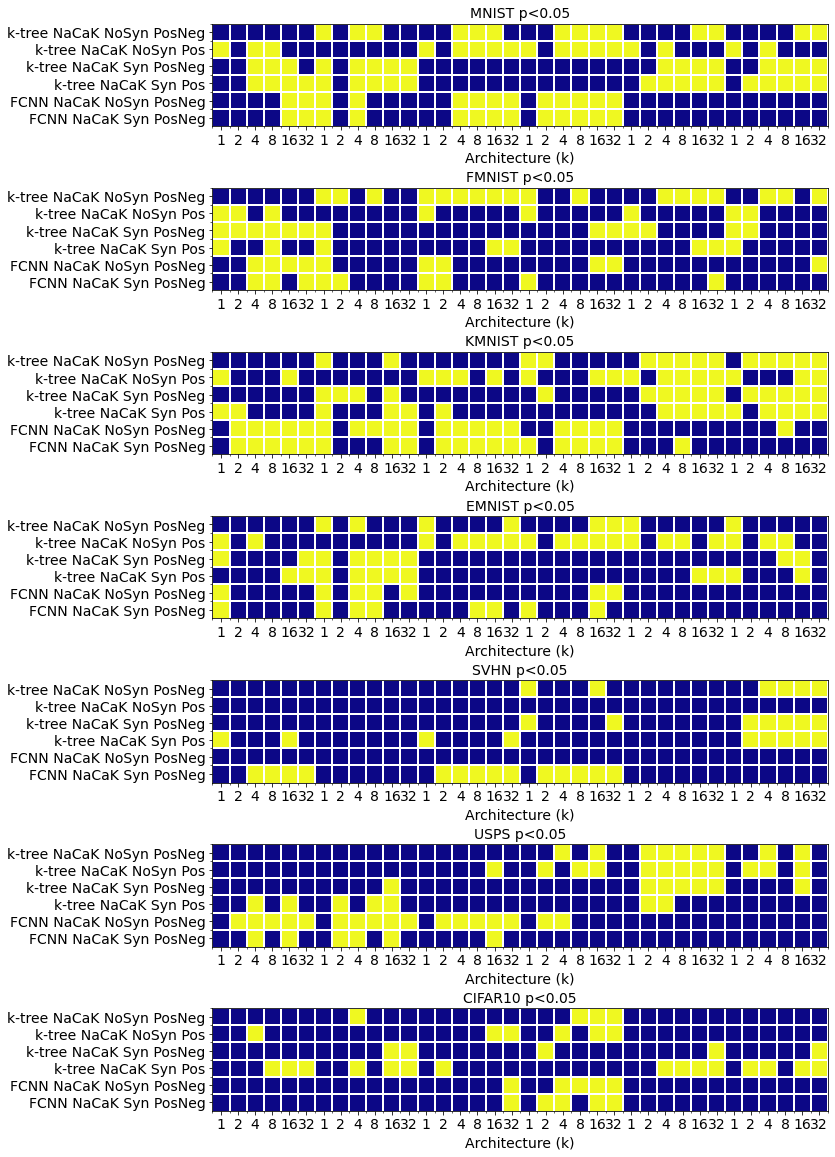

In [325]:
print(nonlin_keys)

nk_num = 6
dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
tree_set_labels = ['1','2','4','8','16','32']
list_of_k = (np.arange(0,6*nk_num)).tolist()


fig, ax = plt.subplots(7, 1, figsize=(15,20))
fig.subplots_adjust(hspace = .6)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):
    p_val_set = np.ones((len(nonlin_keys[:nk_num]), nk_num*6))
    for nk, nonlin_key in enumerate(nonlin_keys[:nk_num]):
        p_vals = comparison_array(acc, nonlin_keys[:nk_num], nonlin_keys[nk], dataset)
        idx = np.isnan(p_vals)
        p_vals[idx] = 1
        p_val_set[nk] = np.concatenate((p_vals))
    
    ax[ds].imshow(p_val_set < 0.05, cmap='plasma')
    ax[ds].set_title(dataset_name[ds]+' p<0.05', fontsize=14)
    ax[ds].tick_params('both', labelsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
   
    # Minor ticks
    ax[ds].set_xticks(np.arange(-.5, 6*nk_num, 1), minor=True)
    ax[ds].set_yticks(np.arange(-.5, nk_num-1, 1), minor=True)
    ax[ds].grid(which="minor", color="w", linestyle='-', linewidth=2)
    
    
    plt.setp(ax[ds], xticks=list_of_k, xticklabels=tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels+
                                                  tree_set_labels,
            yticks=[0, 1, 2, 3, 4,5], yticklabels=labels)
    
    
plt.savefig('./results/figures/sqgl_pval.svg', format='svg')
plt.show()

### Compare Constant SQGL across models without SQGL nosyn pos

- Take highest FCNN value as an upper bound range (look up how to make range lines) and LDA as lower bound range
- Show 1-tree, 1/2-tree and 1/2/4/8/16/32-tree cases
- Show Posneg Syn/NoSyn and Pos Syn/NoSyn separately

In [315]:
# Load Data

DIR_f = './results/20210102/acc'
DIR_f_sqgl = './results/20210210/acc'
DIR_k = './results/20210102/acc'
DIR_k_sqgl = './results/20210210/acc'
model_types = ['ktree','fcnn']
activations = ['sqgl']
syn_keys = ['nosyn', 'syn']
pos_keys = ['posneg','pos']
leaks = [0]

trees_set = [1, 2, 4, 8, 16, 32]

classes = np.load('./results/classes.npy', allow_pickle=True)
datasets = classes[:,2]

acc_f = {}
acc_k = {}
nonlin_keys = []
acc = {}
for model_type in model_types:
    for activation in activations:
        for syn_key in syn_keys:
            if activation != 'sqgl' and syn_key == 'syn':
                break

            for pos_key in pos_keys:
                if model_type == 'fcnn' and pos_key == 'pos':
                    break

                for leak in leaks:
                    if activation != 'relu' and leak == 1.0:
                        break

                    nonlin_group = {}
                    for dataset in datasets:
                        if model_type == 'fcnn':
                            if activation == 'sqgl':
                                dataset_cache = np.load('_'.join((DIR_f_sqgl, model_type, activation, syn_key, pos_key, str(leak), dataset))+'.npy')
                            else:
                                dataset_cache = np.load('_'.join((DIR_f, model_type, activation, syn_key, str(leak), dataset))+'.npy')
                        else:
                            if activation == 'sqgl':
                                dataset_cache = np.load('_'.join((DIR_k_sqgl, model_type, activation, syn_key, pos_key, str(leak), dataset))+'.npy')
                            else:
                                dataset_cache = np.load('_'.join((DIR_k, model_type, activation, syn_key, str(leak), dataset))+'.npy')
                        
                        
                        nonlin_group[dataset] = dataset_cache

                    # Concatenate all datasets by nonlinearity
                    nonlin_key = '_'.join((model_type, activation, syn_key, pos_key, str(leak)))
                    nonlin_keys.append(nonlin_key)

                    acc[nonlin_key] = nonlin_group

acc_lin = np.load('./results/lda_score_test.npy')            

print(nonlin_keys)

['ktree_sqgl_nosyn_posneg_0', 'ktree_sqgl_nosyn_pos_0', 'ktree_sqgl_syn_posneg_0', 'ktree_sqgl_syn_pos_0', 'fcnn_sqgl_nosyn_posneg_0', 'fcnn_sqgl_syn_posneg_0']


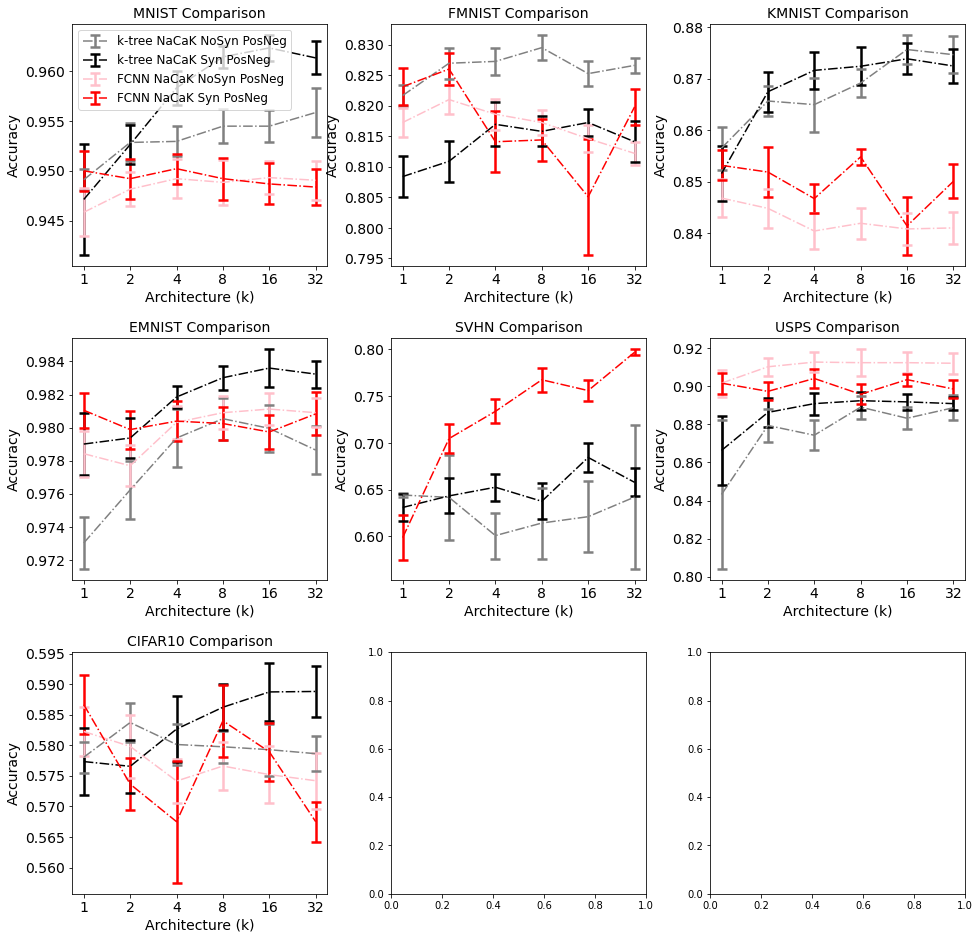

In [316]:
cutoff = 0.55
trees = 6
positivity = False

colors = ['grey', 'yellow', 'black', 'orange', 'pink', 'red']
colors_posneg = ['grey', 'black']
colors_pos = ['yellow', 'orange']
colors_fcnn = ['pink','red']

dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
labels = ['k-tree SQGL NoSyn PosNeg',
         'k-tree SQGL Syn PosNeg',
         'FCNN SQGL NoSyn PosNeg',
         'FCNN SQGL Syn PosNeg',]


acc_mean = np.zeros((7, 6, 6))
acc_std = np.zeros((7, 6, 6))
acc_counts = np.zeros((7, 6, 6))

# acc_mean = np.zeros((6,6))
# acc_std = np.zeros((6,6))
# acc_counts = np.zeros((6,6))

# ktree posneg [0], ktree pos [1], fcnn [2]
nonlin_keys_subsets = [nonlin_keys[0:3:2], nonlin_keys[1:4:2], nonlin_keys[4:6]]


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.25)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):

    x = np.arange(len(trees_set[0:trees]))
        
    # ktree posneg
    for i, nonlin_key in enumerate(nonlin_keys_subsets[0]):
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
       
        ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_posneg[i])
        
    if positivity == True:
        # ktree pos
        for i, nonlin_key in enumerate(nonlin_keys_subsets[1]):
            acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)

            ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_pos[i])

    # fcnn
    for i, nonlin_key in enumerate(nonlin_keys_subsets[2]):
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
       
        ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_fcnn[i])

        
        
    ax[ds].set_xticks(np.arange(len(trees_set[0:trees])))
    ax[ds].set_xticklabels(trees_set[0:trees], fontsize=14)
    ax[ds].set_ylabel('Accuracy', fontsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
    ax[ds].tick_params('y', labelsize=14)

    ax[ds].set_title(dataset_name[ds]+' Comparison', fontsize=14)
    
    if positivity == True:
        labels = [nonlin_keys_subsets[0][0],
                 nonlin_keys_subsets[0][1],
                 nonlin_keys_subsets[1][0],
                 nonlin_keys_subsets[1][1],
                 nonlin_keys_subsets[2][0],
                 nonlin_keys_subsets[2][1]]
    else:
        labels = ['k-tree NaCaK NoSyn PosNeg',
                 'k-tree NaCaK Syn PosNeg',
                 'FCNN NaCaK NoSyn PosNeg',
                 'FCNN NaCaK Syn PosNeg',]
    ax[0].legend(labels, fontsize='large')

plt.savefig('./results/figures/constant_sqgl_compare_syn.svg', format='svg')


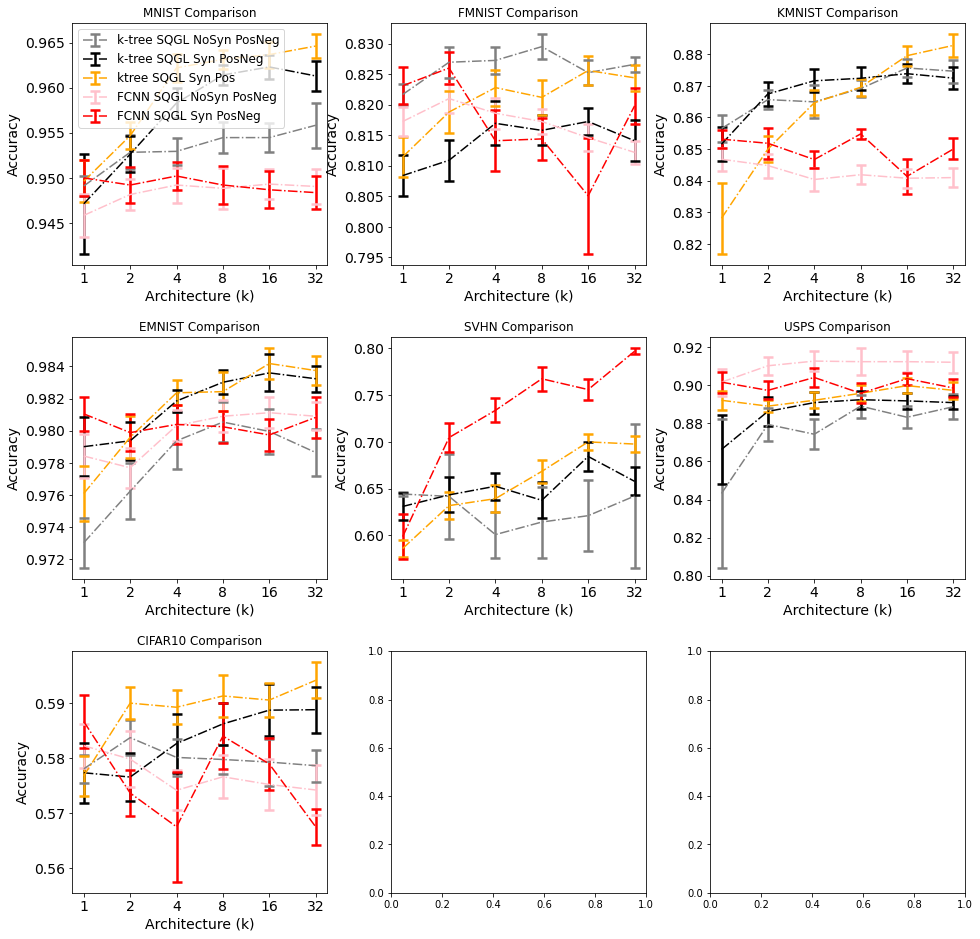

In [49]:
cutoff = 0.55
trees = 6
positivity = True

colors = ['grey', 'yellow', 'black', 'orange', 'pink', 'red']
colors_posneg = ['grey', 'black']
colors_pos = ['yellow', 'orange']
colors_fcnn = ['pink','red']

dataset_name = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']
labels = ['k-tree SQGL NoSyn PosNeg',
          'k-tree SQGL Syn PosNeg',
          'ktree SQGL Syn Pos',
          'FCNN SQGL NoSyn PosNeg',
          'FCNN SQGL Syn PosNeg',]

acc_mean = np.zeros((7, 6, 6))
acc_std = np.zeros((7, 6, 6))
acc_counts = np.zeros((7, 6, 6))

# acc_mean = np.zeros((6,6))
# acc_std = np.zeros((6,6))
# acc_counts = np.zeros((6,6))

# ktree posneg [0], ktree pos [1], fcnn [2]
nonlin_keys_subsets = [nonlin_keys[0:3:2], nonlin_keys[1:4:2], nonlin_keys[4:6]]


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.25)
ax = ax.ravel()

for ds, dataset in enumerate(datasets):

    x = np.arange(len(trees_set[0:trees]))
        
    # ktree posneg
    for i, nonlin_key in enumerate(nonlin_keys_subsets[0]):
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
       
        ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_posneg[i])
        
    if positivity == True:
        # ktree pos
#         for i, nonlin_key in enumerate(nonlin_keys_subsets[1]):
#             acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)

#             ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_pos[i])

        nonlin_key = nonlin_keys_subsets[1][1]
        i = 1
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)

        ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_pos[i])
    # fcnn
    for i, nonlin_key in enumerate(nonlin_keys_subsets[2]):
        acc_mean[ds,i], acc_std[ds,i], acc_counts[ds,i] = mean_std(acc[nonlin_key][dataset], cutoff, sterr=True)
       
        ax[ds].errorbar(x, acc_mean[ds,i,0:trees], yerr=acc_std[ds,i,0:trees], capsize=5, capthick=2.5, elinewidth=2.5, ls='-.',c=colors_fcnn[i])

        
        
    ax[ds].set_xticks(np.arange(len(trees_set[0:trees])))
    ax[ds].set_xticklabels(trees_set[0:trees], fontsize=14)
    ax[ds].set_ylabel('Accuracy', fontsize=14)
    ax[ds].set_xlabel('Architecture (k)', fontsize=14)
    ax[ds].tick_params('y', labelsize=14)

    ax[ds].set_title(dataset_name[ds]+' Comparison')
    
    if positivity == True:
        labels = ['k-tree SQGL NoSyn PosNeg',
                  'k-tree SQGL Syn PosNeg',
                  'ktree SQGL Syn Pos',
                  'FCNN SQGL NoSyn PosNeg',
                  'FCNN SQGL Syn PosNeg',]
    else:
        labels = ['k-tree SQGL NoSyn PosNeg',
                  'k-tree SQGL Syn PosNeg',
                  'FCNN SQGL NoSyn PosNeg',
                  'FCNN SQGL Syn PosNeg',]
    ax[0].legend(labels, fontsize='large')
    
    
plt.savefig('./results/figures/constant_sqgl_compare_all_except_ktreeNosynPos.svg', format='svg')    
